# 📈 Week 7.1 Trading Strategy: Tree-Based Ensemble Methods

---

## 🎯 Strategy Overview

**Building on Weeks 1-7 + Adding Week 7.1 Concepts:**
- Foundation (returns, volatility, correlation)
- Statistics (distributions, hypothesis testing)
- Time series (stationarity, GARCH)
- ML foundations (regression, regularization)
- Portfolio optimization (MPT)
- Factor models (CAPM, Fama-French)
- Classification (logistic, SVM)
- **NEW:** Decision Trees for interpretable rules
- **NEW:** Random Forest for robust predictions
- **NEW:** XGBoost/LightGBM for high accuracy
- **NEW:** Stacking for optimal ensemble

**Strategy Logic:**
1. Engineer comprehensive features
2. Train multiple tree-based models
3. Compare and ensemble predictions
4. Generate robust trading signals

---

In [ ]:
# ============================================================
# CONFIGURATION
# ============================================================
TICKERS = ['AAPL', 'GOOGL', 'MSFT', 'GS', 'JPM']  # Tech + Financials
BENCHMARK = 'SPY'
LOOKBACK_DAYS = 252 * 2
PREDICTION_HORIZON = 5

print("=" * 60)
print("📊 WEEK 7.1 TRADING STRATEGY: TREE ENSEMBLES")
print("=" * 60)
print(f"\n🎯 Analyzing: {TICKERS}")
print(f"📅 Prediction horizon: {PREDICTION_HORIZON} days")

📊 WEEK 7.1 TRADING STRATEGY: TREE ENSEMBLES

🎯 Analyzing: ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']
📅 Prediction horizon: 5 days


In [2]:
# ============================================================
# IMPORTS & DATA
# ============================================================
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, classification_report
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

# Try importing XGBoost and LightGBM
try:
    import xgboost as xgb
    HAS_XGB = True
except ImportError:
    HAS_XGB = False
    
try:
    import lightgbm as lgb
    HAS_LGB = True
except ImportError:
    HAS_LGB = False

# Fetch data
all_tickers = TICKERS + [BENCHMARK]
end_date = datetime.now()
start_date = end_date - timedelta(days=int(LOOKBACK_DAYS * 1.5))

print("\n📥 Downloading market data...")
data = yf.download(all_tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna().tail(LOOKBACK_DAYS)
volumes = data['Volume'].dropna().tail(LOOKBACK_DAYS)
returns = prices.pct_change().dropna()

print(f"✅ Loaded {len(prices)} trading days")
print(f"   XGBoost available: {HAS_XGB}")
print(f"   LightGBM available: {HAS_LGB}")


📥 Downloading market data...
✅ Loaded 504 trading days
   XGBoost available: True
   LightGBM available: True


---

## 📊 Section 1: Feature Engineering

**Creating comprehensive features for tree models:**
- Momentum features
- Volatility features
- Technical indicators
- Volume-based features

In [5]:
# ============================================================
# FEATURE ENGINEERING
# ============================================================

def create_tree_features(prices, returns, volumes, ticker):
    """Create features optimized for tree-based models."""
    df = pd.DataFrame(index=returns.index)
    
    close = prices[ticker]
    ret = returns[ticker]
    
    # Momentum features
    df['ret_1d'] = ret.shift(1)
    df['ret_5d'] = ret.shift(1).rolling(5).sum()
    df['ret_10d'] = ret.shift(1).rolling(10).sum()
    df['ret_20d'] = ret.shift(1).rolling(20).sum()
    
    # Volatility
    df['vol_5d'] = ret.rolling(5).std().shift(1)
    df['vol_20d'] = ret.rolling(20).std().shift(1)
    df['vol_ratio'] = df['vol_5d'] / df['vol_20d']
    
    # Moving averages
    df['ma_ratio_5_20'] = (close.rolling(5).mean() / close.rolling(20).mean() - 1).shift(1)
    df['ma_ratio_10_50'] = (close.rolling(10).mean() / close.rolling(50).mean() - 1).shift(1)
    
    # RSI
    delta = close.diff()
    gain = delta.where(delta > 0, 0).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    df['rsi'] = (100 - (100 / (1 + gain / loss))).shift(1)
    
    # Bollinger Bands
    ma20 = close.rolling(20).mean()
    std20 = close.rolling(20).std()
    df['bb_upper_dist'] = ((close - (ma20 + 2*std20)) / close).shift(1)
    df['bb_lower_dist'] = ((close - (ma20 - 2*std20)) / close).shift(1)
    
    # MACD
    ema12 = close.ewm(span=12).mean()
    ema26 = close.ewm(span=26).mean()
    df['macd'] = (ema12 - ema26).shift(1)
    df['macd_signal'] = df['macd'].ewm(span=9).mean()
    
    # Volume
    if ticker in volumes.columns:
        df['volume_ratio'] = (volumes[ticker] / volumes[ticker].rolling(20).mean()).shift(1)
    
    return df

# Create labels (multi-class: Down, Neutral, Up)
def create_labels(returns, ticker, horizon=PREDICTION_HORIZON, threshold=0.02):
    """Create classification labels (0, 1, 2 for XGBoost compatibility)."""
    future_ret = returns[ticker].shift(-horizon).rolling(horizon).sum()
    labels = pd.Series(index=returns.index, dtype=int)
    labels[future_ret > threshold] = 2   # Up
    labels[future_ret < -threshold] = 0  # Down
    labels[(future_ret >= -threshold) & (future_ret <= threshold)] = 1  # Neutral
    return labels

# Create features and labels for all tickers
features_dict = {}
labels_dict = {}

for ticker in TICKERS:
    features_dict[ticker] = create_tree_features(prices, returns, volumes, ticker)
    labels_dict[ticker] = create_labels(returns, ticker)

print(f"✅ Created {len(features_dict[TICKERS[0]].columns)} features per ticker")
print(f"Features: {list(features_dict[TICKERS[0]].columns)}")

✅ Created 15 features per ticker
Features: ['ret_1d', 'ret_5d', 'ret_10d', 'ret_20d', 'vol_5d', 'vol_20d', 'vol_ratio', 'ma_ratio_5_20', 'ma_ratio_10_50', 'rsi', 'bb_upper_dist', 'bb_lower_dist', 'macd', 'macd_signal', 'volume_ratio']


---

## 📊 Section 2: Model Training & Comparison

**Comparing tree-based models:**
- Decision Tree (baseline)
- Random Forest (bagging)
- Gradient Boosting
- XGBoost (if available)
- LightGBM (if available)

In [6]:
# ============================================================
# MODEL TRAINING
# ============================================================

def train_tree_models(features, labels):
    """Train and compare tree-based models."""
    
    # Align and clean
    common_idx = features.index.intersection(labels.index)
    X = features.loc[common_idx].dropna()
    y = labels.loc[X.index].dropna()
    
    common = X.index.intersection(y.index)
    X = X.loc[common]
    y = y.loc[common]
    
    if len(X) < 200:
        return None
    
    # Time series split
    tscv = TimeSeriesSplit(n_splits=5)
    
    # Train/test split
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    
    # Scale (not required for trees but helps with some models)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Models to compare
    models = {
        'Decision Tree': DecisionTreeClassifier(max_depth=5, random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42),
        'Gradient Boost': GradientBoostingClassifier(n_estimators=100, max_depth=4, random_state=42)
    }
    
    if HAS_XGB:
        models['XGBoost'] = xgb.XGBClassifier(n_estimators=100, max_depth=4, 
                                               random_state=42, use_label_encoder=False,
                                               eval_metric='mlogloss', verbosity=0)
    
    if HAS_LGB:
        models['LightGBM'] = lgb.LGBMClassifier(n_estimators=100, max_depth=4,
                                                 random_state=42, verbose=-1)
    
    results = {}
    for name, model in models.items():
        # Cross-validation
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=tscv, scoring='f1_weighted')
        
        # Fit and predict
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        
        # Feature importance
        if hasattr(model, 'feature_importances_'):
            importance = pd.Series(model.feature_importances_, index=X.columns)
        else:
            importance = None
        
        results[name] = {
            'model': model,
            'scaler': scaler,
            'cv_f1': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'test_acc': accuracy_score(y_test, y_pred),
            'test_f1': f1_score(y_test, y_pred, average='weighted'),
            'predictions': pd.Series(y_pred, index=y_test.index),
            'importance': importance,
            'X_test': X_test,
            'y_test': y_test
        }
    
    return results

# Train for all tickers
print("📊 TREE MODEL COMPARISON")
print("=" * 90)
print(f"\n{'Ticker':<10} {'Model':<18} {'CV F1':>10} {'Test Acc':>12} {'Test F1':>10}")
print("-" * 90)

all_results = {}
for ticker in TICKERS:
    results = train_tree_models(features_dict[ticker], labels_dict[ticker])
    
    if results:
        all_results[ticker] = results
        for model_name, metrics in results.items():
            print(f"{ticker:<10} {model_name:<18} {metrics['cv_f1']:>9.3f} {metrics['test_acc']:>11.2%} {metrics['test_f1']:>9.3f}")
        print()

📊 TREE MODEL COMPARISON

Ticker     Model                   CV F1     Test Acc    Test F1
------------------------------------------------------------------------------------------
AAPL       Decision Tree          0.271      33.33%     0.335
AAPL       Random Forest          0.291      27.78%     0.305
AAPL       Gradient Boost         0.303      20.00%     0.232
AAPL       XGBoost                0.324      16.67%     0.199
AAPL       LightGBM               0.329      21.11%     0.243

MSFT       Decision Tree          0.283      52.22%     0.462
MSFT       Random Forest          0.229      47.78%     0.473
MSFT       Gradient Boost         0.229      28.89%     0.304
MSFT       XGBoost                0.248      26.67%     0.289
MSFT       LightGBM               0.260      28.89%     0.306

GOOGL      Decision Tree          0.314      32.22%     0.296
GOOGL      Random Forest          0.292      46.67%     0.340
GOOGL      Gradient Boost         0.302      41.11%     0.302
GOOGL      

📊 AVERAGE FEATURE IMPORTANCE (Random Forest)
vol_20d           0.085491
macd_signal       0.084558
macd              0.079491
ma_ratio_10_50    0.072236
vol_5d            0.070940
bb_upper_dist     0.070866
vol_ratio         0.068820
ret_20d           0.064814
bb_lower_dist     0.063823
ret_10d           0.063727


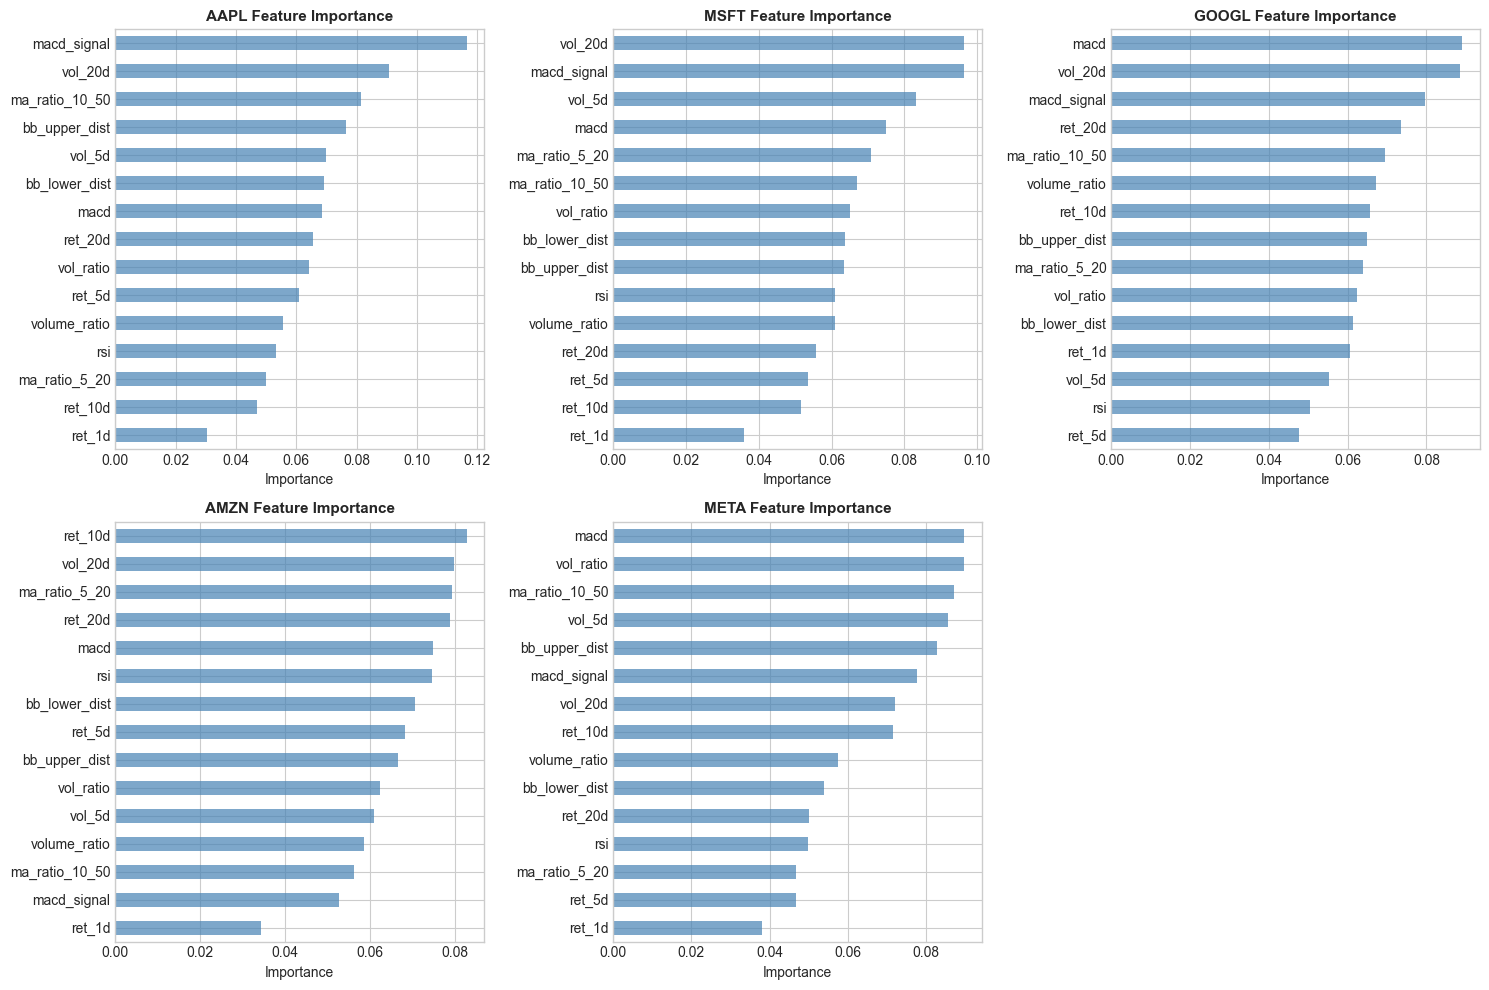

In [7]:
# ============================================================
# FEATURE IMPORTANCE ANALYSIS
# ============================================================

print("📊 AVERAGE FEATURE IMPORTANCE (Random Forest)")
print("=" * 60)

# Aggregate importance across tickers
all_importance = pd.DataFrame()
for ticker in TICKERS:
    if ticker in all_results and 'Random Forest' in all_results[ticker]:
        imp = all_results[ticker]['Random Forest']['importance']
        if imp is not None:
            all_importance[ticker] = imp

if len(all_importance.columns) > 0:
    avg_importance = all_importance.mean(axis=1).sort_values(ascending=False)
    print(avg_importance.head(10).to_string())

# Visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, ticker in enumerate(TICKERS):
    ax = axes[i]
    if ticker in all_results and 'Random Forest' in all_results[ticker]:
        imp = all_results[ticker]['Random Forest']['importance']
        if imp is not None:
            imp.sort_values().plot(kind='barh', ax=ax, color='steelblue', alpha=0.7)
            ax.set_title(f'{ticker} Feature Importance', fontsize=11, fontweight='bold')
            ax.set_xlabel('Importance')

axes[-1].axis('off')
plt.tight_layout()
plt.show()

---

## 📊 Section 3: Ensemble Stacking

**Combining models for robust predictions:**
- Use best tree models as base learners
- Logistic regression as meta-learner
- Cross-validated stacking

In [8]:
# ============================================================
# STACKING ENSEMBLE
# ============================================================

def create_stacking_model(features, labels):
    """Create a stacking ensemble."""
    
    common_idx = features.index.intersection(labels.index)
    X = features.loc[common_idx].dropna()
    y = labels.loc[X.index].dropna()
    common = X.index.intersection(y.index)
    X = X.loc[common]
    y = y.loc[common]
    
    if len(X) < 200:
        return None, None, None, None
    
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Base models
    base_models = [
        ('rf', RandomForestClassifier(n_estimators=50, max_depth=4, random_state=42)),
        ('gb', GradientBoostingClassifier(n_estimators=50, max_depth=3, random_state=42))
    ]
    
    if HAS_XGB:
        base_models.append(('xgb', xgb.XGBClassifier(n_estimators=50, max_depth=3, 
                                                      random_state=42, use_label_encoder=False,
                                                      eval_metric='mlogloss', verbosity=0)))
    
    # Stacking
    stack = StackingClassifier(
        estimators=base_models,
        final_estimator=LogisticRegression(max_iter=1000),
        cv=5
    )
    
    stack.fit(X_train_scaled, y_train)
    y_pred = stack.predict(X_test_scaled)
    
    return stack, scaler, accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='weighted')

print("📊 STACKING ENSEMBLE RESULTS")
print("=" * 60)

stack_results = {}
for ticker in TICKERS:
    stack, scaler, acc, f1 = create_stacking_model(features_dict[ticker], labels_dict[ticker])
    if stack:
        stack_results[ticker] = {'model': stack, 'scaler': scaler, 'acc': acc, 'f1': f1}
        print(f"{ticker}: Accuracy={acc:.2%}, F1={f1:.3f}")

📊 STACKING ENSEMBLE RESULTS
AAPL: Accuracy=42.22%, F1=0.365
MSFT: Accuracy=60.00%, F1=0.480
GOOGL: Accuracy=40.00%, F1=0.241
AMZN: Accuracy=34.44%, F1=0.290
META: Accuracy=24.44%, F1=0.184


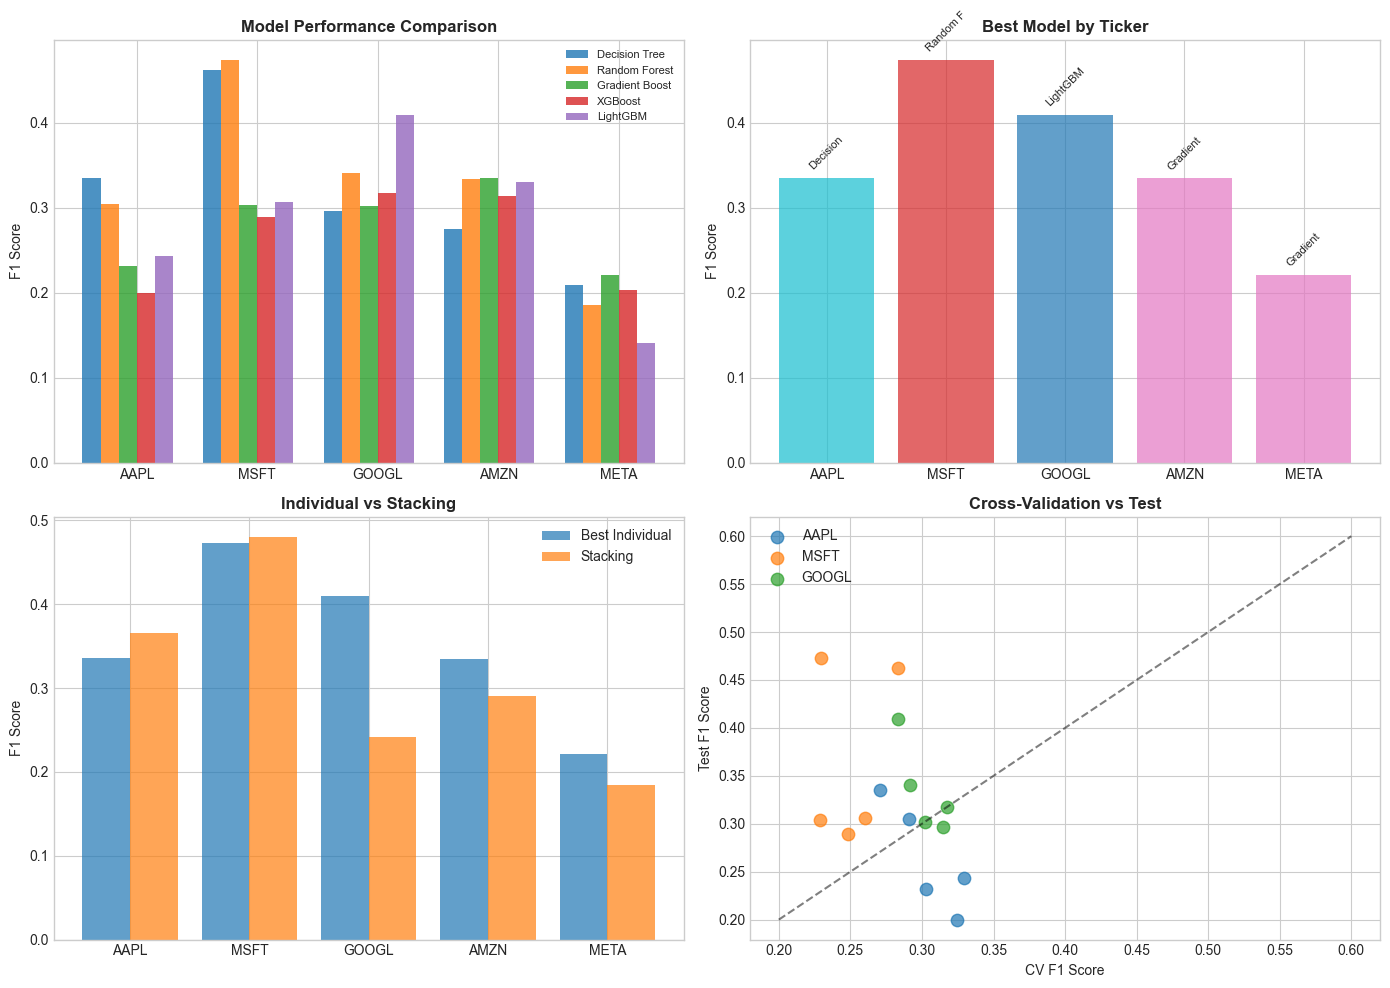

In [9]:
# ============================================================
# MODEL COMPARISON VISUALIZATION
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. F1 Score by Model and Ticker
ax1 = axes[0, 0]
model_names = ['Decision Tree', 'Random Forest', 'Gradient Boost']
if HAS_XGB:
    model_names.append('XGBoost')
if HAS_LGB:
    model_names.append('LightGBM')

x = np.arange(len(TICKERS))
width = 0.15

for i, model in enumerate(model_names):
    f1_scores = []
    for ticker in TICKERS:
        if ticker in all_results and model in all_results[ticker]:
            f1_scores.append(all_results[ticker][model]['test_f1'])
        else:
            f1_scores.append(0)
    ax1.bar(x + i*width, f1_scores, width, label=model, alpha=0.8)

ax1.set_xticks(x + width * len(model_names) / 2)
ax1.set_xticklabels(TICKERS)
ax1.set_ylabel('F1 Score')
ax1.set_title('Model Performance Comparison', fontsize=12, fontweight='bold')
ax1.legend(fontsize=8, loc='upper right')

# 2. Best Model per Ticker
ax2 = axes[0, 1]
best_models = []
best_f1s = []
for ticker in TICKERS:
    if ticker in all_results:
        best = max(all_results[ticker].items(), key=lambda x: x[1]['test_f1'])
        best_models.append(best[0])
        best_f1s.append(best[1]['test_f1'])
    else:
        best_models.append('N/A')
        best_f1s.append(0)

colors = plt.cm.tab10(np.linspace(0, 1, len(set(best_models))))
color_map = dict(zip(set(best_models), colors))
bar_colors = [color_map[m] for m in best_models]

ax2.bar(TICKERS, best_f1s, color=bar_colors, alpha=0.7)
for i, (t, m, f) in enumerate(zip(TICKERS, best_models, best_f1s)):
    ax2.text(i, f + 0.01, m[:8], ha='center', fontsize=8, rotation=45)
ax2.set_ylabel('F1 Score')
ax2.set_title('Best Model by Ticker', fontsize=12, fontweight='bold')

# 3. Stacking vs Best Individual
ax3 = axes[1, 0]
individual_best = [max([all_results[t][m]['test_f1'] for m in all_results[t]]) 
                   if t in all_results else 0 for t in TICKERS]
stacking_f1 = [stack_results[t]['f1'] if t in stack_results else 0 for t in TICKERS]

x = np.arange(len(TICKERS))
ax3.bar(x - 0.2, individual_best, 0.4, label='Best Individual', alpha=0.7)
ax3.bar(x + 0.2, stacking_f1, 0.4, label='Stacking', alpha=0.7)
ax3.set_xticks(x)
ax3.set_xticklabels(TICKERS)
ax3.set_ylabel('F1 Score')
ax3.set_title('Individual vs Stacking', fontsize=12, fontweight='bold')
ax3.legend()

# 4. CV vs Test Performance
ax4 = axes[1, 1]
for ticker in TICKERS[:3]:
    if ticker in all_results:
        cv_scores = [all_results[ticker][m]['cv_f1'] for m in model_names if m in all_results[ticker]]
        test_scores = [all_results[ticker][m]['test_f1'] for m in model_names if m in all_results[ticker]]
        ax4.scatter(cv_scores, test_scores, s=80, label=ticker, alpha=0.7)

ax4.plot([0.2, 0.6], [0.2, 0.6], 'k--', alpha=0.5)
ax4.set_xlabel('CV F1 Score')
ax4.set_ylabel('Test F1 Score')
ax4.set_title('Cross-Validation vs Test', fontsize=12, fontweight='bold')
ax4.legend()

plt.tight_layout()
plt.show()

In [10]:
# ============================================================
# TRADING SIGNALS
# ============================================================

def get_ensemble_signal(ticker, all_results, stack_results, features_dict):
    """Get trading signal from ensemble."""
    if ticker not in stack_results:
        if ticker not in all_results:
            return {'signal': 'N/A', 'confidence': 0}
        # Use best individual model
        best = max(all_results[ticker].items(), key=lambda x: x[1]['test_f1'])
        model = best[1]['model']
        scaler = best[1]['scaler']
        model_name = best[0]
    else:
        model = stack_results[ticker]['model']
        scaler = stack_results[ticker]['scaler']
        model_name = 'Stacking'
    
    # Get latest features
    features = features_dict[ticker].dropna().iloc[[-1]]
    if len(features) == 0:
        return {'signal': 'N/A', 'confidence': 0, 'model': model_name}
    
    X_scaled = scaler.transform(features)
    pred = model.predict(X_scaled)[0]
    
    if hasattr(model, 'predict_proba'):
        probs = model.predict_proba(X_scaled)[0]
        confidence = max(probs)
    else:
        confidence = 0.5
    
    signal = 'BUY' if pred == 1 else ('SELL' if pred == -1 else 'HOLD')
    
    return {
        'signal': signal,
        'confidence': confidence,
        'model': model_name,
        'prediction': pred
    }

print("📊 CURRENT TRADING SIGNALS")
print("=" * 75)
print(f"\n{'Ticker':<10} {'Model':<18} {'Signal':>10} {'Confidence':>12}")
print("-" * 75)

current_signals = {}
for ticker in TICKERS:
    signal_info = get_ensemble_signal(ticker, all_results, stack_results, features_dict)
    current_signals[ticker] = signal_info
    
    emoji = "📈" if signal_info['signal'] == 'BUY' else ("📉" if signal_info['signal'] == 'SELL' else "⚪")
    print(f"{ticker:<10} {signal_info['model']:<18} {emoji} {signal_info['signal']:>6} {signal_info['confidence']:>11.1%}")

📊 CURRENT TRADING SIGNALS

Ticker     Model                  Signal   Confidence
---------------------------------------------------------------------------
AAPL       Stacking           📈    BUY       44.6%
MSFT       Stacking           📈    BUY       67.8%
GOOGL      Stacking           📈    BUY       52.9%
AMZN       Stacking           ⚪   HOLD       39.4%
META       Stacking           ⚪   HOLD       39.3%


In [11]:
# ============================================================
# FINAL RECOMMENDATIONS
# ============================================================

print("\n" + "=" * 80)
print("📊 WEEK 7.1 STRATEGY - FINAL RECOMMENDATIONS")
print("=" * 80)

# Summary
summary = pd.DataFrame({
    'Model': [current_signals[t]['model'] for t in TICKERS],
    'Signal': [current_signals[t]['signal'] for t in TICKERS],
    'Confidence': [current_signals[t]['confidence'] for t in TICKERS]
}, index=TICKERS)

print("\n📋 SIGNAL SUMMARY:")
print(summary.to_string())

# Recommendations
buys = [t for t in TICKERS if current_signals[t]['signal'] == 'BUY']
sells = [t for t in TICKERS if current_signals[t]['signal'] == 'SELL']
holds = [t for t in TICKERS if current_signals[t]['signal'] == 'HOLD']

print("\n🏆 RECOMMENDATIONS:")
print(f"\n📈 BUY: {buys if buys else 'None'}")
print(f"📉 SELL: {sells if sells else 'None'}")
print(f"⚪ HOLD: {holds if holds else 'None'}")

# High confidence
high_conf = [(t, current_signals[t]) for t in TICKERS 
             if current_signals[t]['confidence'] > 0.5 and current_signals[t]['signal'] != 'HOLD']

if high_conf:
    print("\n⭐ HIGH CONFIDENCE TRADES:")
    for ticker, info in high_conf:
        print(f"   {ticker}: {info['signal']} ({info['model']}, Confidence: {info['confidence']:.1%})")

print("\n" + "=" * 80)
print("⚠️ DISCLAIMER: Educational purposes only. Not financial advice!")
print("=" * 80)


📊 WEEK 7.1 STRATEGY - FINAL RECOMMENDATIONS

📋 SIGNAL SUMMARY:
          Model Signal  Confidence
AAPL   Stacking    BUY    0.446333
MSFT   Stacking    BUY    0.678399
GOOGL  Stacking    BUY    0.528756
AMZN   Stacking   HOLD    0.393591
META   Stacking   HOLD    0.393174

🏆 RECOMMENDATIONS:

📈 BUY: ['AAPL', 'MSFT', 'GOOGL']
📉 SELL: None
⚪ HOLD: ['AMZN', 'META']

⭐ HIGH CONFIDENCE TRADES:
   MSFT: BUY (Stacking, Confidence: 67.8%)
   GOOGL: BUY (Stacking, Confidence: 52.9%)

⚠️ DISCLAIMER: Educational purposes only. Not financial advice!


---

## 📚 Key Concepts Used (Week 1-7.1)

| Week | Concept | Application |
|------|---------|-------------|
| 1 | Returns & Volatility | Feature engineering |
| 2 | Statistical Testing | Model validation |
| 3 | Time Series | Temporal features |
| 4 | ML Regression | Baseline models |
| 5 | Portfolio Theory | Position sizing |
| 6 | Factor Models | Factor features |
| 6.1 | Classification | Signal generation |
| **7.1** | **Decision Trees** | **Interpretable rules** |
| **7.1** | **Random Forest** | **Robust predictions** |
| **7.1** | **XGBoost/LightGBM** | **High accuracy** |
| **7.1** | **Stacking** | **Ensemble signals** |

---